In [5]:
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps

In [3]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

In [7]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=2),
)

model.fit(x_train, t=dt)

x_sim = model.simulate(x_train[0], time_steps)

In [8]:
model.print()

(x0)' = -9.977 x0 + 9.977 x1
(x1)' = 27.808 x0 + -0.963 x1 + -0.995 x0 x2
(x2)' = -2.659 x2 + 0.997 x0 x1


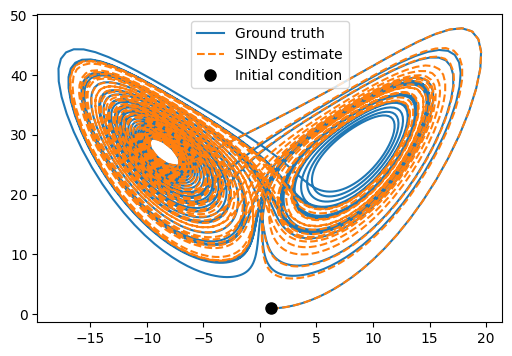

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

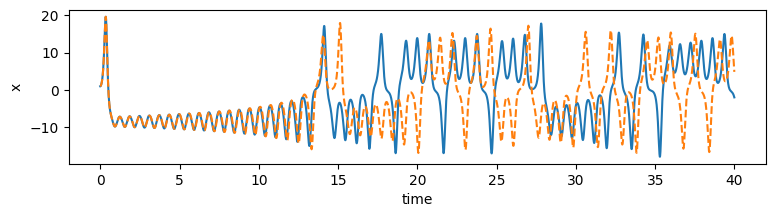

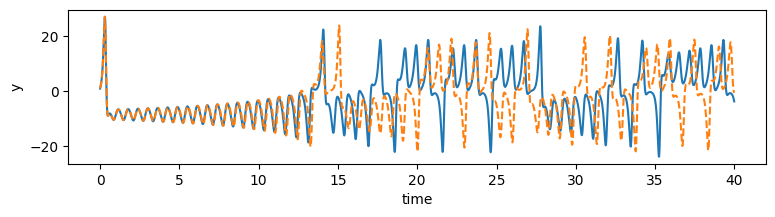

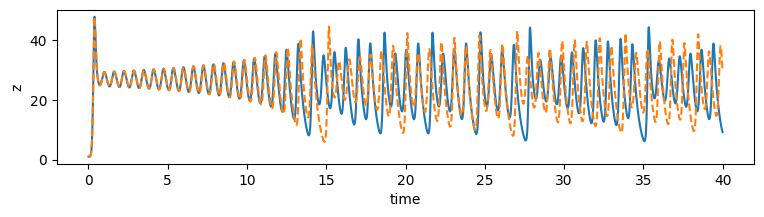

In [10]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

In [85]:
from scipy import sparse

radius = 0.6
sparsity = 0.01
input_dim = 3
reservoir_size = 1000
n_steps_prerun = 10
regularization = 1e-2
sequence = x_train

In [86]:
weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

weights_input = np.zeros((reservoir_size, input_dim))
q = int(reservoir_size / input_dim)
for i in range(0, input_dim):
    weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1

weights_output = np.zeros((input_dim, reservoir_size))

In [87]:
save_weights = list(weights_input)

In [88]:
def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
    hidden = np.zeros((reservoir_size, 1))
    for t in range(n_steps_prerun):
        input = sequence[t].reshape(-1, 1)
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    return hidden

def augment_hidden(hidden):
    h_aug = hidden.copy()
    h_aug[::2] = pow(h_aug[::2], 2.0)
    return h_aug

hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
hidden_states = []
targets = []

for t in range(n_steps_prerun, len(sequence) - 1):
    input = np.reshape(sequence[t], (-1, 1))
    target = np.reshape(sequence[t + 1], (-1, 1))
    hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    hidden = augment_hidden(hidden)
    hidden_states.append(hidden)
    targets.append(target)

targets = np.squeeze(np.array(targets))
hidden_states = np.squeeze(np.array(hidden_states))

In [89]:
weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

In [90]:
def predict(sequence, n_steps_predict):
    hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
    input = sequence[n_steps_prerun].reshape((-1, 1))
    outputs = []

    for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
        hidden = augment_hidden(hidden)
        output = weights_output @ hidden
        input = output
        outputs.append(output)
    return np.array(outputs)

In [91]:
x_sim = predict(sequence, 4000)

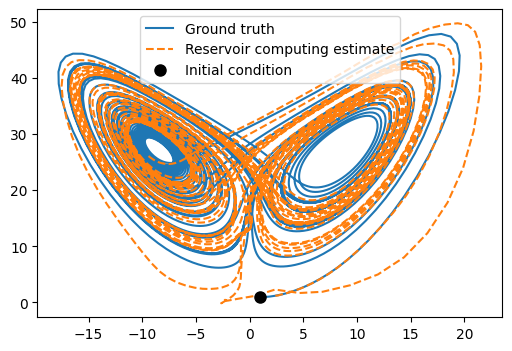

In [92]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:4000, 0], x_train[:4000, 2], label="Ground truth")
plt.plot(x_sim[:, 0], x_sim[:, 2],'--', label="Reservoir computing estimate")
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)

plt.legend()
plt.show()

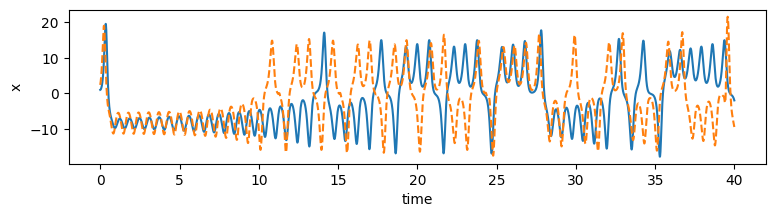

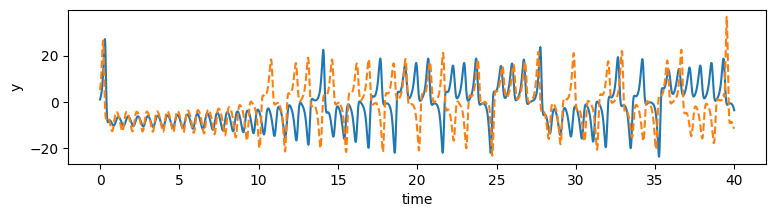

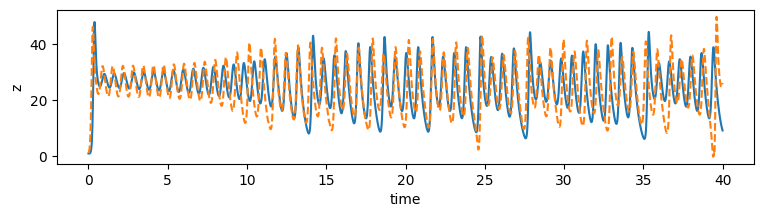

In [93]:
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

In [ ]:
for i in range(10):
    